In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

### Plot flash drought, soil moisture, and potential evaporation data

In [ ]:
#File path for HUC4 1005
flash_drought_path = 'path/result_HUC4_1005.csv'

# Load datasets
flash_drought_df = pd.read_csv(flash_drought_path)

# Filter and preprocess data for the specified date range
start_date = '2017-01-01'
end_date = '2017-12-31'

# Flash drought data
flash_drought_df['Date'] = pd.to_datetime(flash_drought_df['Date'])
flash_drought_df = flash_drought_df[(flash_drought_df['Date'] >= start_date) & (flash_drought_df['Date'] <= end_date)]

In [3]:
#calculte the mean daily precipitation
# Load datasets
flash_drought_pr = pd.read_csv(flash_drought_path,parse_dates=['Date'])
flash_drought_pr['Month']=flash_drought_pr['Date'].dt.month
flash_drought_pr['Day']=flash_drought_pr['Date'].dt.day

daily_mean_pr=flash_drought_pr.groupby(['Month','Day'])['precipitation'].mean().reset_index()
print(daily_mean_pr)

     Month  Day  precipitation
0        1    1       0.732836
1        1    2       0.793493
2        1    3       0.480053
3        1    4       0.457649
4        1    5       0.956907
..     ...  ...            ...
361     12   27       0.976070
362     12   28       1.018209
363     12   29       1.252611
364     12   30       0.977284
365     12   31       0.518486

[366 rows x 3 columns]


In [4]:
# Ensure month and day values are strings and properly formatted
daily_mean_pr['Month'] = daily_mean_pr['Month'].astype(int)
daily_mean_pr['Day'] = daily_mean_pr['Day'].astype(int)

# Construct the full date (assuming a known year, e.g., 2022)
daily_mean_pr['Full_Date'] = pd.to_datetime(
    '2017-' + daily_mean_pr['Month'].astype(str) + '-' + daily_mean_pr['Day'].astype(str), 
    errors='coerce'  # This will convert invalid dates to NaT instead of raising an error
)

# Drop rows with NaT values (invalid dates)
daily_mean_pr = daily_mean_pr.dropna(subset=['Full_Date'])

In [5]:
# List of methods
methods = ["Alencar et al.", "Noguera et al.", "Osman et al.", 
           "Ford and Labosier", "Pendergrass et al.", "Christian et al."]

# Initialize a list to store the results
event_list = []

# Loop through each method to find start and end dates of flash drought events
for method in methods:
    df = flash_drought_df[['Date', method]].copy()
    
    # Identify start (0 to 1) and end (1 to 0) of flash drought events
    df['Start'] = (df[method].diff() == 1)
    df['End'] = (df[method].diff() == -1)
    
    # Get start and end dates
    start_dates = df.loc[df['Start'], 'Date'].values
    end_dates = df.loc[df['End'], 'Date'].values
    
    # Handle case where an event is ongoing at the end of the dataset
    if len(start_dates) > len(end_dates):
        end_dates = list(end_dates) + [df['Date'].iloc[-1]]
    
    # Store results in a structured format
    for start, end in zip(start_dates, end_dates):
        event_list.append({'Method': method, 'Start_Date': start, 'End_Date': end})

# Convert results into a DataFrame
flash_drought_events = pd.DataFrame(event_list)

# Display the result
print(flash_drought_events)


               Method Start_Date   End_Date
0      Alencar et al. 2017-05-05 2017-06-30
1      Noguera et al. 2017-04-23 2017-08-02
2        Osman et al. 2017-05-06 2017-08-04
3        Osman et al. 2017-08-14 2017-09-18
4   Ford and Labosier 2017-05-16 2017-06-25
5  Pendergrass et al. 2017-04-28 2017-08-04
6  Pendergrass et al. 2017-08-11 2017-09-15
7  Pendergrass et al. 2017-11-10 2017-12-29
8    Christian et al. 2017-05-01 2017-06-10


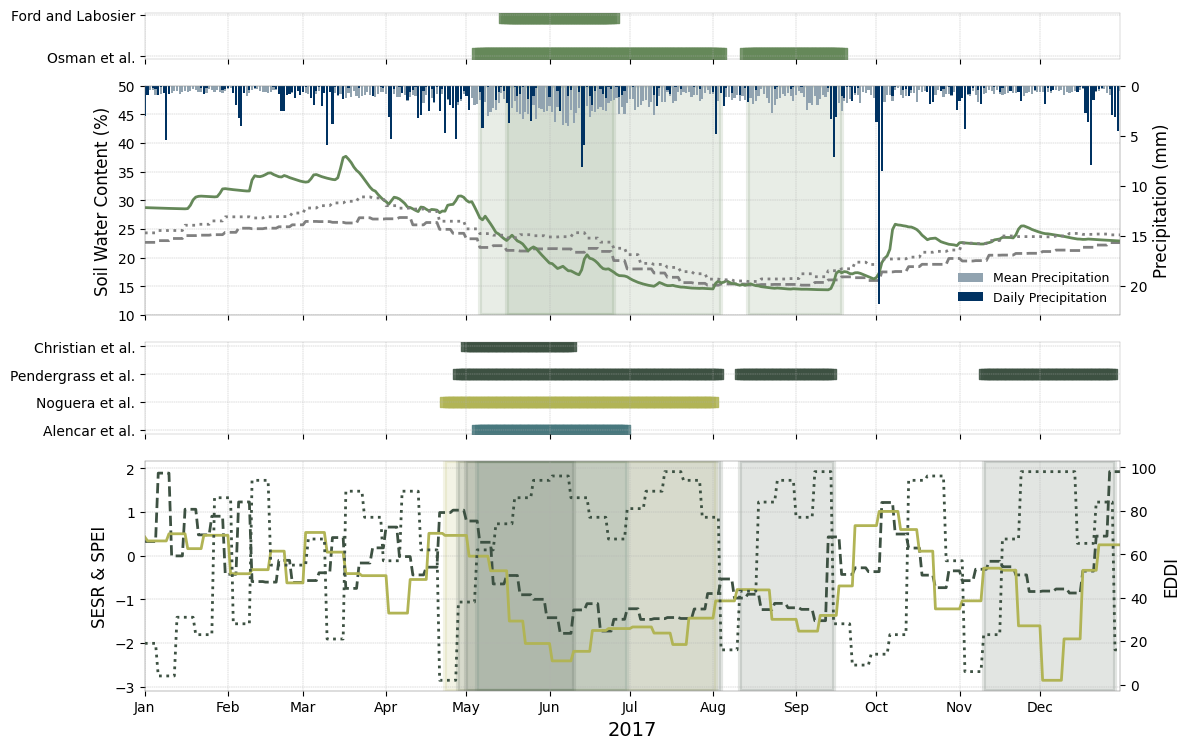

In [ ]:
# Create figure and subplots
# Create figure and subplots (now 4 instead of 3)
fig, (ax1a, ax2, ax1b, ax3) = plt.subplots(4, 1, figsize=(12, 8), sharex=True,
                               gridspec_kw={'height_ratios': [0.2,1,0.4, 1]})

# Define methods and corresponding colors
methods = ["Alencar et al.", "Noguera et al.", "Osman et al.", 
           "Ford and Labosier", "Pendergrass et al.", "Christian et al."]
colors = ["#48787E", "#B1B455", "#658859", "#658859", "#3D5142", "#3D5142"]

# Define subplot groups
subplot_2_methods = ["Osman et al.", "Ford and Labosier"]
subplot_3_methods = ["Alencar et al.", "Noguera et al.", "Pendergrass et al.", "Christian et al."]

# Define soil water content variables
swc_columns = ['swc_p20', "swc", 'swc_p40']
swc_legend_names = ['swc p20', 'swc', 'swc p40']
swc_styles = ['dashed', '-', 'dotted']
swc_colors = ['grey', "#658859", 'grey']

# Define ET variables
et_columns = ['sesr', 'spei', 'eddi']
et_legend_names = ['SESR', 'SPEI', 'EDDI']
et_styles = ['dashed', '-', 'dotted']
et_colors = ['#3D5142', "#B1B455", '#3D5142']  # EDDI in distinct color


# 1.1 Plot Ford and Labosier & Osman et al. flash droughts
time_spacing = 1
for i, method in enumerate(subplot_2_methods):
    indices = flash_drought_df['Date'][flash_drought_df[method] == 1]
    method_idx = methods.index(method)
    ax1a.scatter(indices, [i * time_spacing] * len(indices), c=colors[method_idx], 
                 marker='s', s=120, alpha=0.85, label=method)

ax1a.set_yticks([i * time_spacing for i in range(len(subplot_2_methods))])
ax1a.set_yticklabels(subplot_2_methods)
ax1a.grid(True, linestyle='--', linewidth=0.3)

# 2. Plot Soil Water Content + Precipitation
for i, column in enumerate(swc_columns):
    ax2.plot(flash_drought_df['Date'], flash_drought_df[column], label=swc_legend_names[i], 
             color=swc_colors[i], linestyle=swc_styles[i], linewidth=2)

ax2.set_ylabel('Soil Water Content (%)', fontsize=12)
ax2.grid(True, linestyle='--', linewidth=0.3)

ax2_2 = ax2.twinx()
ax2_2.bar(daily_mean_pr['Full_Date'], daily_mean_pr["precipitation"], 
          color="#91A3B0", label="Mean Precipitation")
ax2_2.bar(flash_drought_df['Date'], flash_drought_df['precipitation'], 
          color="#003262", label="Daily Precipitation")

ax2_2.invert_yaxis()
ax2_2.set_ylabel('Precipitation (mm)', fontsize=12)
ax2.set_ylim(10, 50)

# Legend for precipitation (lower right inside plot)
precip_handles, precip_labels = ax2_2.get_legend_handles_labels()
ax2.legend(precip_handles, precip_labels, loc='lower right', fontsize=9, frameon=False)


# 3. Plot Other Flash Drought Indicators
for i, method in enumerate(subplot_3_methods):
    indices = flash_drought_df['Date'][flash_drought_df[method] == 1]
    method_idx = methods.index(method)
    ax1b.scatter(indices, [i * time_spacing] * len(indices), c=colors[method_idx], 
                 marker='s', s=50, alpha=0.85, label=method)

ax1b.set_yticks([i * time_spacing for i in range(len(subplot_3_methods))])
ax1b.set_yticklabels(subplot_3_methods)
ax1b.grid(True, linestyle='--', linewidth=0.3)

# 4. Plot ET Variables with Dual Y-Axis
ax3_twin = ax3.twinx()
lines, labels = [], []
for i, column in enumerate(et_columns[:-1]):
    line, = ax3.plot(flash_drought_df['Date'], flash_drought_df[column], label=et_legend_names[i], 
                     color=et_colors[i], linestyle=et_styles[i], linewidth=2)
    lines.append(line)
    labels.append(et_legend_names[i])

line, = ax3_twin.plot(flash_drought_df['Date'], flash_drought_df['eddi'], label='EDDI',
                      color=et_colors[-1], linestyle=et_styles[-1], linewidth=2)
lines.append(line)
labels.append('EDDI')

ax3.set_ylabel('SESR & SPEI', fontsize=12)
ax3_twin.set_ylabel('EDDI', fontsize=12)
ax3.set_xlabel('2017', fontsize=14)
ax3.grid(True, linestyle='--', linewidth=0.3)

# Set X-axis ticks and formatting
ax3.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
ax3.set_xticks(pd.date_range(start=start_date, end=end_date, freq='MS'))
ax3.set_xticklabels([date.strftime('%b') for date in pd.date_range(start=start_date, end=end_date, freq='MS')])

# Add shaded regions to relevant subplots
for _, row in flash_drought_events.iterrows():
    method, start, end = row["Method"], row["Start_Date"], row["End_Date"]
    color = colors[methods.index(method)]

    if method in subplot_2_methods:
        ax2.axvspan(start, end, color=color, alpha=0.15, linewidth=3)
    if method in subplot_3_methods:
        ax3.axvspan(start, end, color=color, alpha=0.15, linewidth=3)

# Aesthetic border color
for ax in [ax1a, ax1b, ax2, ax2_2, ax3, ax3_twin]:
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.2)

# Save figure
fig.savefig('path/plot_1005_2017.png', format='png', dpi=600, transparent=True)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### Plot USDA's National Agricultural Statistics Service for Montana

In [ ]:
## Read file
df= pd.read_csv('path/USDA_montanaState.csv')

In [3]:
#Create a subset of the data with 'Year' and 'Value'
Crop_totals=df[['Year', 'Value']].copy()

In [4]:
#Convert the 'Value' column to float
Crop_totals['Value'] = Crop_totals['Value'].str.replace(',', '', regex=False).astype(float)

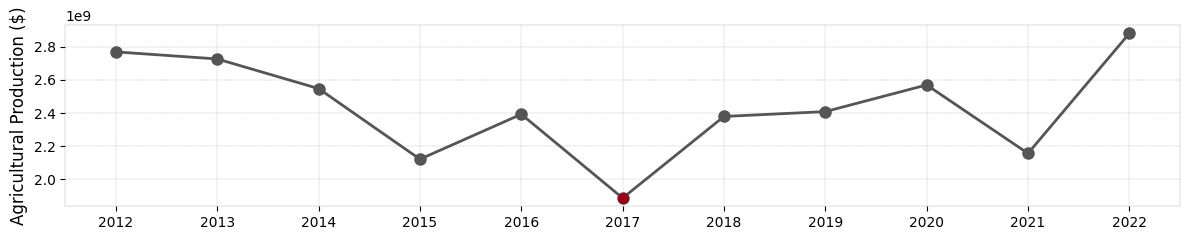

In [ ]:
# Filter for years between 2012 and 2022
crop_totals_filtered = Crop_totals[(Crop_totals['Year'] >= 2012) & (Crop_totals['Year'] <= 2022)]

# Create the figure
fig, ax = plt.subplots(figsize=(12, 2.5))
# Set years of interest for x-axis ticks and markers
ax.set_xticks(list(range(2012, 2023)))

# Plot the line
ax.plot(crop_totals_filtered['Year'], crop_totals_filtered['Value'],
        label='Agricultural Sales', color='#555555',
        linestyle='-', marker='o', markersize=8, linewidth=2)

# Highlight 2017 in red if it exists in the filtered data
if 2017 in crop_totals_filtered['Year'].values:
    value_2017 = crop_totals_filtered.loc[crop_totals_filtered['Year'] == 2017, 'Value'].values[0]
    ax.plot(2017, value_2017, marker='o', color='#960018', markersize=7)

# Labels and styling
ax.set_ylabel('Agricultural Production ($)', fontsize=12)
ax.set_xticks(list(range(2012, 2023)))
ax.grid(True, linestyle='--', linewidth=0.3)

for spine in ax.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(0.2)

# Save and show the figure
fig.savefig('path/agriculture_sales_2012_2022.png',
            format='png', dpi=300, transparent=True)

plt.tight_layout()
plt.show()